In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

def make_bins(xlim,dx):
    Edges_x = np.arange(xlim[0],xlim[1]+dx,dx)
    Bins_x = Edges_x[:-1]+dx/2
    return Edges_x,Bins_x

def ind_match(x,A):
    return np.argwhere(A == x)[:,0][0]

#### Load in and do some cleaning

In [3]:
path = '../DataFrames/df_road_v3_zeros.csv'
df_road = pd.read_csv(path)

- this shows years of availabiliy for accidents and how many per year

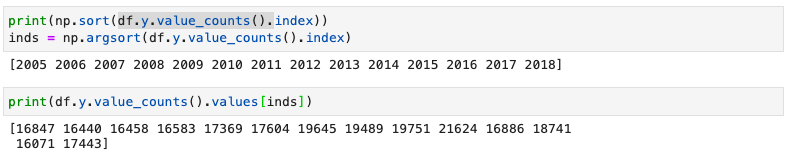

In [17]:
Ys = 2005 #must start before or on this year
Ye = 2018 #must end this year or later

Igap = df_road.Max_year_gap == 1 #we don't want gaps
Istart = df_road.Year_start <= Ys
Iend = df_road.Year_end >= Ye
Iyears = Igap & Istart & Iend

df_road_sub = df_road.loc[Iyears,:].copy()

In [19]:
df_road.columns

Index(['ID', 'total', 'slight', 'serious', 'neigh', 'Road_name', 'Road_name2',
       'h', 'Day_of_Week', 'm', 'Speed_limit', 'Junction_Detail',
       'Junction_Control', 'Pedestrian_Crossing-Physical_Facilities',
       'bikelane', 'aadf_Road_name', 'aadf_Road_category', 'aadf_Road_type',
       'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_Link_length_miles',
       'distance_to_cp', 'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches', 'total_dnorm',
       'total_dnorm_bvnorm', 'serious_ratio', 'N_year', 'Year_start',
       'Year_end', 'Max_year_gap'],
      dtype='object')

#### Select the features to use in clustering dataframe 
- but not neccesarily use for clustering

In [20]:
f_include = ['ID', 'total', 'slight', 'serious',
       'bikelane', 'aadf_Road_name', 'aadf_Road_category', 'aadf_Road_type',
       'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_Link_length_miles',
       'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches', 'total_dnorm',
       'total_dnorm_bvnorm', 'serious_ratio']

df_cluster = df_road_sub[f_include].copy()

#### Scale the continuous data

In [24]:
f_scale = ['aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches']

for f in f_scale:
    mean = df_cluster[f].mean()
    std = df_cluster[f].std()
    df_cluster.loc[:,f] = (df_cluster[f].values - mean)/std

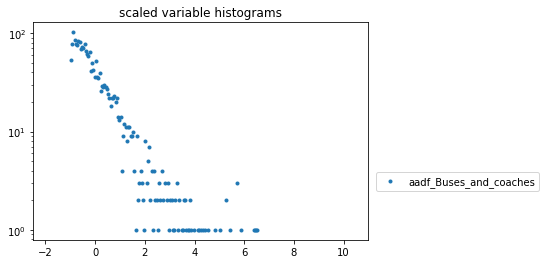

In [39]:
#histogram the scaled variables

dx = 0.05
x_r = (-10,10)
e_x,b_x = make_bins(x_r,dx)

fig,ax = plt.subplots()

f_plot = ['aadf_Buses_and_coaches']
for f in f_plot:
    H,_ = np.histogram(df_cluster[f].values,bins=e_x)
    ax.plot(b_x,H,label=f,marker='.',linestyle='none')
    
ax.set_title('scaled variable histograms')
ax.legend(bbox_to_anchor=(1.01,0.2),loc='lower left')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim(-2.5)
plt.show()

#### Goals with clustering

- Try and find clusters of roads with similar properties
- Might be good to pick subset of features for a first try (maybe ignore some of the unbanced classifiers)
- Simple accident statistics can then be calculated on these groupings. Are some better than others?
- Should probably do some cross validation on the groups that were found in the training set to see the variance of the accident statistics (we want error bars on the accident statistics)

In [41]:
df_cluster.columns

Index(['ID', 'total', 'slight', 'serious', 'bikelane', 'aadf_Road_name',
       'aadf_Road_category', 'aadf_Road_type', 'aadf_CLT_CARR',
       'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_Link_length_miles',
       'aadf_Pedal_cycles', 'aadf_All_motor_vehicles', 'aadf_All_HGVs',
       'aadf_LGVs', 'aadf_Buses_and_coaches', 'total_dnorm',
       'total_dnorm_bvnorm', 'serious_ratio'],
      dtype='object')

In [45]:
#print out %s of data in each classifier class

f_class = ['aadf_CLT_CARR',
       'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME']

for f in f_class:
    print(df_cluster.loc[df_cluster.bikelane,f].value_counts(True))
    print()

True     0.833588
False    0.166412
Name: aadf_CLT_CARR, dtype: float64

False    0.756489
True     0.243511
Name: aadf_CLT_SEGREG, dtype: float64

False    0.960305
True     0.039695
Name: aadf_CLT_STEPP, dtype: float64

False    0.69542
True     0.30458
Name: aadf_CLT_PARSEG, dtype: float64

True     0.735878
False    0.264122
Name: aadf_CLT_SHARED, dtype: float64

False    0.718321
True     0.281679
Name: aadf_CLT_MANDAT, dtype: float64

True     0.587023
False    0.412977
Name: aadf_CLT_ADVIS, dtype: float64

False    0.718321
True     0.281679
Name: aadf_CLT_PRIORI, dtype: float64

False    0.773282
True     0.226718
Name: aadf_CLT_CONTRA, dtype: float64

True     0.530534
False    0.469466
Name: aadf_CLT_BIDIRE, dtype: float64

False    0.979389
True     0.020611
Name: aadf_CLT_CBYPAS, dtype: float64

False    0.975573
True     0.024427
Name: aadf_CLT_BBYPAS, dtype: float64

False    0.855725
True     0.144275
Name: aadf_CLT_PARKR, dtype: float64

False    0.975573
True     0.024

In [66]:
#pick which features to try clustering on
f_cluster = ['bikelane','aadf_Pedal_cycles', 'aadf_All_motor_vehicles', 'aadf_All_HGVs',
       'aadf_LGVs', 'aadf_Buses_and_coaches']

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [68]:
clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [95]:
ktry = np.arange(1,10+1,1).astype(int)
Nk = len(ktry)

cluster_centers = [None]*Nk
inertias = np.zeros(Nk)
Isil = ktry != 1
ksil = ktry[Isil]
Nsil = Isil.sum()
sil_scores = np.zeros(Nsil)
sm_group = np.zeros(Nsil) #smallest group by fraction
group_sizes = [None]*Nsil

ii_sil = 0
for ii,k in enumerate(ktry):
    KM = KMeans(k)
    
    KM.fit(df_cluster[f_cluster])
    cluster_centers[ii] = KM.cluster_centers_
    
    inertias[ii] = KM.inertia_
    
    if k != 1:
        clusters = KM.predict(df_cluster[f_cluster])
        sil_scores[ii_sil] = silhouette_score(df_cluster[f_cluster],clusters)
        VCs = pd.value_counts(clusters,normalize=True)
        group_sizes[ii_sil] = VCs
        sm_group[ii_sil] = VCs.min()*k #this shows % of smallest group relative to an even split
            #among groups
        ii_sil +=1

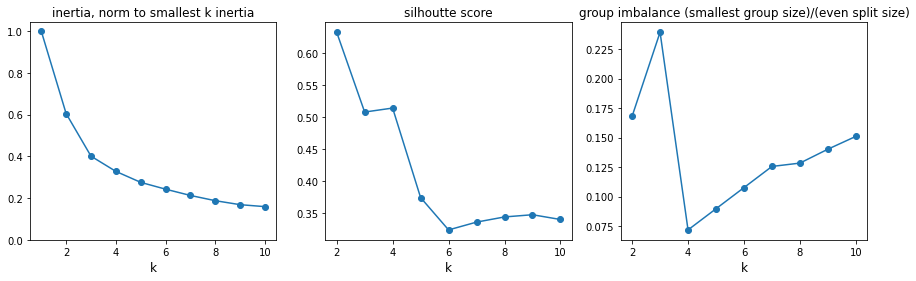

In [96]:
fig,ax = plt.subplots(1,3,figsize=(3*5,4))
labsize = 12

ii=0
ax[ii].plot(ktry,inertias/inertias[0],marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('inertia, norm to smallest k inertia',fontsize=labsize)
ax[ii].set_ylim(0)

ii=1
ax[ii].plot(ksil,sil_scores,marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('silhoutte score',fontsize=labsize)

ii=2
ax[ii].plot(ksil,sm_group,marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('group imbalance (smallest group size)/(even split size)',fontsize=labsize)

plt.show()

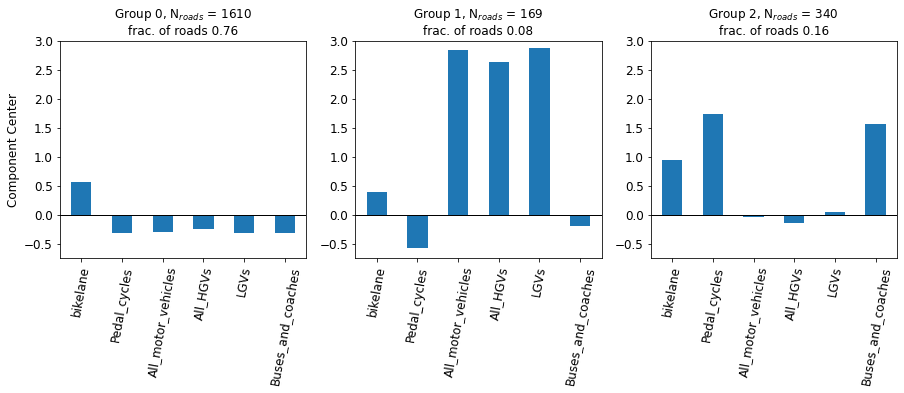

In [143]:
#make a bar plot of the cluster vectors

k = 3
ind = ind_match(k,ktry)
Nfeat_c = len(f_cluster)
Nroads = df_cluster.shape[0]

KM = KMeans(k)
KM.fit(df_cluster[f_cluster])
cluster_centers = KM.cluster_centers_
cluster_IDs = KM.predict(df_cluster[f_cluster])

ticklabs = []
for ii,f in enumerate(f_cluster):
    s = f.split('aadf_')
    if len(s) > 1:
        ticklabs.append(s[1])
    else:
        ticklabs.append(s[0])

fig,ax = plt.subplots(1,k,figsize=(k*5,4))
for ii in range(k):
    ii_try = ind_match(k,ktry)
    ii_sil = ind_match(k,ksil)
    
    I = cluster_IDs == ii
    n_roads_group = I.sum()
    frac_group = n_roads_group/Nroads
    
    ax[ii].bar(np.arange(Nfeat_c),cluster_centers[ii],width=0.5)
    ax[ii].set_ylim(-0.75,3)
    ax[ii].set_xticks(np.arange(Nfeat_c))
    ax[ii].set_xticklabels(ticklabs,rotation=80,fontsize=12)
    ax[ii].tick_params(labelsize=labsize)
    ax[ii].set_title('Group %i, N$_{roads}$ = %i \nfrac. of roads %.2f'%(ii,n_roads_group,
                                                                        frac_group))
    ax[ii].axhline(0,0,1,linewidth=1,color='black')
    if ii == 0:
        ax[ii].set_ylabel('Component Center',fontsize=labsize)
    
plt.show()

In [137]:
group_sizes

[0    0.915998
 1    0.084002
 dtype: float64,
 0    0.759792
 2    0.160453
 1    0.079755
 dtype: float64,
 0    0.739028
 3    0.159981
 2    0.083058
 1    0.017933
 dtype: float64,
 0    0.601227
 4    0.234545
 3    0.083530
 2    0.062765
 1    0.017933
 dtype: float64,
 0    0.352997
 4    0.311468
 2    0.179330
 1    0.082114
 3    0.056159
 5    0.017933
 dtype: float64,
 6    0.330345
 4    0.305805
 0    0.159037
 5    0.083058
 3    0.069844
 2    0.033978
 1    0.017933
 dtype: float64,
 7    0.302501
 0    0.290703
 3    0.161869
 6    0.073148
 4    0.065125
 1    0.059462
 2    0.031147
 5    0.016045
 dtype: float64,
 1    0.288344
 5    0.282681
 4    0.150071
 6    0.075979
 3    0.072676
 7    0.057574
 0    0.038226
 8    0.018877
 2    0.015573
 dtype: float64,
 4    0.285040
 0    0.279377
 9    0.140160
 7    0.077395
 2    0.075979
 8    0.042001
 6    0.037282
 3    0.029259
 5    0.018405
 1    0.015101
 dtype: float64]